<a href="https://colab.research.google.com/github/BobbyRex/IBM-Capstone-Battle-of-the-neighborhoods/blob/Final/Best_Neighborhood_for_French_cuisine_in_Toronto_(week_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using Foursquare data and neighbourhood profiles to find the best spot in Toronto to start up a French cuisine

####*Background* 
According to the last census, more than 50,000 Torontonians identified themselves as francophones. Every year roughly 1,000 French-speaking immigrants settle in Toronto, with the occasional spike – after the 2011 earthquake in Haiti, for example [1](https://www.theglobeandmail.com/news/toronto/a-cultural-shift-for-toronto-as-invisible-francophones-settle-in/article26232519/). There is, however, no defined francophone neighborhood in Toronto. For those who wish to start up a French cuisine, this project aims to select the best neighborhood in Toronto for this matter. Variables taken into account includes e.g. french speaking rate, average income, crime rate, migration rate, restaurant frequency.

####*Material and methods*
Datasets on  [Toronto neighborhood profiles](https://open.toronto.ca/dataset/neighbourhood-profiles/) and crime statistics from the [Toronto Police Service](https://data.torontopolice.on.ca/pages/asr-open-data) will be merged. Restaurants, grouped by neighborhood, will be obtained through requests from the Foursquare API. A score will be calculated based on selected variables predicted to influence the decision. Top scoring neighborhoods will be suberimposed over a map of Toronto using Folium. The relative contribution of each selected variable to the final score will be calculated and plotted. The provided material will serve as basis for further exploration of the neighborhoods by the customer wishing to start up a French Cuisine in Toronto.

####First, lets import the required libraries:

In [57]:
%matplotlib inline 
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
import io
from bs4 import BeautifulSoup
print('Libraries imported.')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
from sklearn.metrics import r2_score

####Variables needed later to access Geopy and Foursquare API

In [2]:
#Foursquare
CLIENT_ID = 'BJYOEN12FKXPVNXL53N3E0IYSTUKWRXIN0KWV5L5HUQOTV2C' 
CLIENT_SECRET = 'AW2MRYSVU3O2FBZRMUSZ3LBMKZK5K0REYASL5BDSF15DYBGY' 
VERSION = '20180604'
LIMIT = 300 

#Getting coordinates of Toronto
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address, timeout=15)
latitude = location.latitude
longitude = location.longitude

####Let's define the functions needed later on

In [3]:
def get_toronto_data():
#To import downloaded dataset on Toronto census from https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv 
  from google.colab import files
  uploaded = files.upload()
  demographics = pd.read_csv(io.BytesIO(uploaded['neighbourhood-profiles-2016-csv.csv']), thousands=',')
  return demographics

def get_crime_rates():
# to fetch crime data from the Toronto Police and calculate a total crime rate per neighborhood  
  !wget -q -O 'crimes.json' "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/Neighbourhood_MCI/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
  
  with open('crimes.json') as json_data:
    crime_data = json.load(json_data)
  
  features = crime_data['features']
  
  column_names = ['Neighborhood', "Assault rate", "Autotheft rate", "Breakandenter rate", "Homicide rate", "Robbery rate", "Theftover rate"] 
  crimes = pd.DataFrame(columns=column_names)

  for data in features:
    neigh = data['attributes']['Neighbourhood'] 
    assault = data['attributes']['Assault_Rate_2019']
    auto = data['attributes']['AutoTheft_Rate_2019']
    bae = data['attributes']['BreakandEnter_Rate_2019']
    homicide = data['attributes']['Homicide_Rate_2019']
    robbery = data['attributes']['Robbery_Rate_2019']
    theft = data['attributes']['TheftOver_Rate_2019']
    crimes = crimes.append({'Neighborhood': neigh,
                                          'Assault rate': assault,
                                          'Autotheft rate': auto,
                                          'Breakandenter rate': bae,
                                          'Homicide rate': homicide,
                                          'Robbery rate': robbery,
                                          'Theftover rate': theft}, ignore_index=True)

  crimes['Total crime rate'] = crimes.sum(axis=1)
  return(crimes)


def getNearbyVenues(names, latitudes, longitudes, radius=1000):
#fix to only fetch restaurants?   
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',
                  'id', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

##1. Construct a demographics dataframe
####I will use the neighbourhood profiles 2016 dataset from the [Toronto open data portal](https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv):

In [4]:
to_data = get_toronto_data() 
to_data.head()

Saving neighbourhood-profiles-2016-csv.csv to neighbourhood-profiles-2016-csv.csv


,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,75,120,33,123,92,66,59,47,126,93,26,83,62,9,138,5,32,11,13,44,102,101,25,65,140,53,88,87,134,48,8,21,22,106,125,14,90,110,124,78,6,15,114,117,38,105,103,56,84,19,132,29,12,130,17,135,73,115,2,99,104,18,50,36,82,68,74,121,107,54,58,80,45,23,67,46,10,72,4,111,86,98,131,89,28,139,85,70,40,116,16,118,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,No Designation,NIA,No Designation,No Designation,No Designation,NIA,NIA,Emerging Neighbourhood,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,NIA,NIA,No Designation,NIA,No Designation,No Designation,NIA,NIA,No 

####First, some clean-up is required as well as transposing the dataset

In [5]:
to_data.drop(['_id', 'Category', 'Topic', 'Data Source'], axis=1, inplace=True)
to_data=to_data.transpose()
to_data.head()

0                     1     \
Characteristic                Neighbourhood Number  TSNS2020 Designation   
City of Toronto                                NaN                   NaN   
Agincourt North                                129        No Designation   
Agincourt South-Malvern West                   128        No Designation   
Alderwood                                       20        No Designation   

                                          2                 3     \
Characteristic                Population, 2016  Population, 2011   
City of Toronto                      2,731,571         2,615,060   
Agincourt North                         29,113            30,279   
Agincourt South-Malvern West            23,757            21,988   
Alderwood                               12,054            11,904   

                                                     4     \
Characteristic                Population Change 2011-2016   
City of Toronto                                     4.50%   
Agincourt North                                    -3.90%   
Agincourt South-Malvern West                        8.00%   
Alderwood                                           1.30%   

                                                 5     \
Characteristic                Total private dwellings   
City of Toronto                             1,179,057   
Agincourt North                                 9,371   
Agincourt South-Malvern West                    8,535   
Alderwood                                       4,732   

                                                                       6     \
Characteristic                Private dwellings occupied by usual residents   
City of Toronto                                                   1,112,929   
Agincourt North                                                       9,120   
Agincourt South-Malvern West                                          8,136   
Alderwood                                                             4,616   

                                                                 7     \
Characteristic                Population density per square kilometre   
City of Toronto                                                 4,334   
Agincourt North                                                 3,929   
Agincourt South-Malvern West                                    3,034   
Alderwood                                                       2,435   

                                                        8     \
Characteristic                Land area in square kilometres   
City of Toronto                                        630.2   
Agincourt North                                         7.41   
Agincourt South-Malvern West                            7.83   
Alderwood                                               4.95   

                                               9                    10    \
Characteristic                Children (0-14 years)  Youth (15-24 years)   
City of Toronto                             398,135              340,270   
Agincourt North                               3,840                3,705   
Agincourt South-Malvern West                  3,075                3,360   
Alderwood                                     1,760                1,235   

                                                   11    \
Characteristic                Working Age (25-54 years)   
City of Toronto                               1,229,555   
Agincourt North                                  11,305   
Agincourt South-Malvern West                      9,965   
Alderwood                                         5,220   

                                                      12    \
Characteristic                Pre-retirement (55-64 years)   
City of Toronto                                    336,670   
Agincourt North                                      4,230   
Agincourt South-Malvern West                         3,265   
Alderwood                                        

####There is a lot of interesting info here, I will pick a few related to population, income and French speakers

In [128]:
#French restaurant
to_selected=to_data[[2, 4, 7, 129, 130, 2272]]
to_selected.head()

,2,4,7,129,130,2272
Characteristic,"Population, 2016",Population Change 2011-2016,Population density per square kilometre,French only,English and French,Total income: Average amount ($)
City of Toronto,"2,731,571",4.50%,"4,334","2,725","245,695","52,268"
Agincourt North,"29,113",-3.90%,"3,929",15,"1,235","30,414"
Agincourt South-Malvern West,"23,757",8.00%,"3,034",5,"1,060","31,825"
Alderwood,"12,054",1.30%,"2,435",0,890,"47,709"


####The first row should be the column names:

In [129]:
to_selected.reset_index(inplace=True)
to_selected.columns = to_selected.iloc[0]
to_selected = to_selected[1:]
to_selected.head()

,Characteristic,"Population, 2016",Population Change 2011-2016,Population density per square kilometre,French only,English and French,Total income: Average amount ($)
1,City of Toronto,"2,731,571",4.50%,"4,334","2,725","245,695","52,268"
2,Agincourt North,"29,113",-3.90%,"3,929",15,"1,235","30,414"
3,Agincourt South-Malvern West,"23,757",8.00%,"3,034",5,"1,060","31,825"
4,Alderwood,"12,054",1.30%,"2,435",0,890,"47,709"
5,Annex,"30,526",4.60%,"10,863",10,"6,015","112,766"


In [130]:
to_selected.dtypes

0
Characteristic                             object
Population, 2016                           object
Population Change 2011-2016                object
Population density per square kilometre    object
  French only                              object
  English and French                       object
Total income: Average amount ($)           object
dtype: object

####Several of the columns are of dtype object so have to be changed to integers. I found it easiest to first convert them to floats, then integers:

In [131]:
#Since the columns where of dtype object, I first had to change them to floats, then ints
to_selected["Population, 2016"]=to_selected["Population, 2016"].str.replace(',', '').astype(float)
to_selected["Population Change 2011-2016"]=to_selected["Population Change 2011-2016"].str.replace('%', '').astype(float)
to_selected["Population density per square kilometre"]=to_selected["Population density per square kilometre"].str.replace(',', '').astype(float)
to_selected["  French only"]=to_selected["  French only"].str.replace(',', '').astype(float)
to_selected["  English and French"]=to_selected["  English and French"].str.replace(',', '').astype(float)
to_selected["Total income: Average amount ($)"]=to_selected["Total income: Average amount ($)"].str.replace(',', '').astype(float)
to_selected["Population, 2016"]=to_selected["Population, 2016"].astype("int64")
to_selected["Population Change 2011-2016"]=to_selected["Population Change 2011-2016"].astype("int64")
to_selected["Population density per square kilometre"]=to_selected["Population density per square kilometre"].astype("int64")
to_selected["  French only"]=to_selected["  French only"].astype("int64")
to_selected["  English and French"]=to_selected["  English and French"].astype("int64")
to_selected["Total income: Average amount ($)"]=to_selected["Total income: Average amount ($)"].astype("int64")
to_selected.dtypes

0
Characteristic                             object
Population, 2016                            int64
Population Change 2011-2016                 int64
Population density per square kilometre     int64
  French only                               int64
  English and French                        int64
Total income: Average amount ($)            int64
dtype: object

####Let's add a column with the percentage of French-speakers in the neighborhood

In [132]:
to_selected["French speaking (%)"]=((to_selected["  French only"]+to_selected["  English and French"])/to_selected["Population, 2016"])*100
to_selected.head()

,Characteristic,"Population, 2016",Population Change 2011-2016,Population density per square kilometre,French only,English and French,Total income: Average amount ($),French speaking (%)
1,City of Toronto,2731571,4,4334,2725,245695,52268,9.094400
2,Agincourt North,29113,-3,3929,15,1235,30414,4.293615
3,Agincourt South-Malvern West,23757,8,3034,5,1060,31825,4.482889
4,Alderwood,12054,1,2435,0,890,47709,7.383441
5,Annex,30526,4,10863,10,6015,112766,19.737273


####Some further cleaning:

In [133]:
to_selected["Latitude"]=''                                                                                    #adding latitude column
to_selected["Longitude"]=''                                                                                   #adding longitude column
to_selected=to_selected[['Characteristic', 'Population Change 2011-2016',
       'Population density per square kilometre', 'Total income: Average amount ($)',
       'French speaking (%)', 'Latitude', 'Longitude']]                                                       #removing some columns and changing orders
to_selected=to_selected.rename(columns = {'Characteristic': 'Neighborhood', 
                                          "Population Change 2011-2016": "+/- Population(%)",
                                          "Population density per square kilometre": "Population/sqkm",
                                          "  French only": "French only", 
                                          "  English and French": "English and French", 
                                          "Total income: Average amount ($)":"Average income ($}"})            #changing name of column to neighborhood 
to_selected.drop([1], inplace=True)
to_selected.reset_index(inplace=True)
del to_selected['index']                                                                                      #fixing the index
to_selected.head()

,Neighborhood,+/- Population(%),Population/sqkm,Average income ($},French speaking (%),Latitude,Longitude
0,Agincourt North,-3,3929,30414,4.293615,,
1,Agincourt South-Malvern West,8,3034,31825,4.482889,,
2,Alderwood,1,2435,47709,7.383441,,
3,Annex,4,10863,112766,19.737273,,
4,Banbury-Don Mills,2,2775,67757,10.525366,,


##2. Geocoding for adresses and coordinates
####Geopy's geolocator is used, first to get geocodes from neighborhoods:

In [134]:
geolocator = Nominatim(user_agent="foursquare_agent")
to_selected['full_address'] = to_selected.Neighborhood + ", Toronto, ON"
to_selected['gcode'] = to_selected.full_address.apply(geolocator.geocode)
to_selected['gcode']

0      (Agincourt North, Scarborough North, Scarborou...
1      (CTV Agincourt Studios, 9, Channel Nine Court,...
2      (Alderwood, Etobicoke—Lakeshore, Etobicoke, To...
3      (The Annex, University—Rosedale, Old Toronto, ...
4      (Banbury Road, York Mills Road, Don Valley Wes...
5      (Former Bathurst Manor Plaza grounds, York Cen...
6      (Bay Street, Yorkville, University—Rosedale, O...
7      (Bayview Village, Don Valley North, North York...
8      (Bayview Woods-Steeles, Don Valley North, Nort...
9                                                   None
10                                                  None
11     (Bendale, Scarborough Centre, Scarborough, Tor...
12                                                  None
13     (Black Creek, York, North York, Toronto, Golde...
14                                                  None
15                                                  None
16                                                  None
17     (Broadview North, Toront

####Some geocodes were not found, these are moved from to_selected to a separate dataframe (to_missing):

In [135]:
to_missing = to_selected[to_selected["gcode"].isna()]
to_missing.reset_index(inplace=True)
del to_missing["index"]
to_selected.dropna(subset = ['gcode'], inplace=True)

####Now we can get the coordinates for the to_selected dataframe:

In [136]:
to_selected['Latitude'] = [g.latitude for g in to_selected.gcode]
to_selected['Longitude'] = [g.longitude for g in to_selected.gcode]

####For the neighborhoods without g.adresses (in to_missing), coordinates were manually found by googling and subsequently added:

In [137]:
for row in to_missing.itertuples():
    if to_missing.iloc[row.Index, 0] == 'Agincourt South-Malvern West' :
        to_missing.iloc[row.Index, 5] =  43.7925
        to_missing.iloc[row.Index, 6] =  -79.283889
    elif to_missing.iloc[row.Index, 0] == 'Bedford Park-Nortown' :
        to_missing.iloc[row.Index, 5] =  43.73
        to_missing.iloc[row.Index, 6] =  -79.411
    elif to_missing.iloc[row.Index, 0] == 'Cabbagetown-South St. James Town' :
        to_missing.iloc[row.Index, 5] =  43.620543
        to_missing.iloc[row.Index, 6] =  -79.47793
    elif to_missing.iloc[row.Index, 0] == 'Downsview-Roding-CFB' :
        to_missing.iloc[row.Index, 5] =  43.732222
        to_missing.iloc[row.Index, 6] =  -79.493333
    elif to_missing.iloc[row.Index, 0] == 'Mimico (includes Humber Bay Shores)' :
        to_missing.iloc[row.Index, 5] =  43.612778
        to_missing.iloc[row.Index, 6] =  -79.494167
    elif to_missing.iloc[row.Index, 0] == 'Beechborough-Greenbrook' :
        to_missing.iloc[row.Index, 5] =  43.6943
        to_missing.iloc[row.Index, 6] =  -79.4748
    elif to_missing.iloc[row.Index, 0] == 'Birchcliffe-Cliffside' :
        to_missing.iloc[row.Index, 5] =  43.7089
        to_missing.iloc[row.Index, 6] =  -79.2485
    elif to_missing.iloc[row.Index, 0] == 'Bridle Path-Sunnybrook-York Mills' :
        to_missing.iloc[row.Index, 5] =  43.7359
        to_missing.iloc[row.Index, 6] =  -79.3719
    elif to_missing.iloc[row.Index, 0] == 'Brookhaven-Amesbury' :
        to_missing.iloc[row.Index, 5] =  43.6969
        to_missing.iloc[row.Index, 6] =  -79.4938
    elif to_missing.iloc[row.Index, 0] == 'Clairlea-Birchmount' :
        to_missing.iloc[row.Index, 5] =  43.7162
        to_missing.iloc[row.Index, 6] =  -79.2828
    elif to_missing.iloc[row.Index, 0] == 'Dovercourt-Wallace Emerson-Junction' :
        to_missing.iloc[row.Index, 5] =  43.663
        to_missing.iloc[row.Index, 6] =  -79.441
    elif to_missing.iloc[row.Index, 0] == 'Eringate-Centennial-West Deane' :
        to_missing.iloc[row.Index, 5] =  43.6599
        to_missing.iloc[row.Index, 6] =  -79.5833
    elif to_missing.iloc[row.Index, 0] == 'Greenwood-Coxwell' :
        to_missing.iloc[row.Index, 5] =  43.6721
        to_missing.iloc[row.Index, 6] =  -79.3228
    elif to_missing.iloc[row.Index, 0] == 'Humbermede' :
        to_missing.iloc[row.Index, 5] =  43.746297
        to_missing.iloc[row.Index, 6] =  -79.541186
    elif to_missing.iloc[row.Index, 0] == 'Islington-City Centre West' :
        to_missing.iloc[row.Index, 5] =  43.6309
        to_missing.iloc[row.Index, 6] =  -79.5435
    elif to_missing.iloc[row.Index, 0] == 'Leaside-Bennington' :
        to_missing.iloc[row.Index, 5] =  43.708
        to_missing.iloc[row.Index, 6] =  -79.368
    elif to_missing.iloc[row.Index, 0] == 'Mount Olive-Silverstone-Jamestown' :
        to_missing.iloc[row.Index, 5] =  43.739722
        to_missing.iloc[row.Index, 6] =  -79.580278
    elif to_missing.iloc[row.Index, 0] == 'Parkwoods-Donalda' :
        to_missing.iloc[row.Index, 5] =  43.7528
        to_missing.iloc[row.Index, 6] =  -79.3264
    elif to_missing.iloc[row.Index, 0] == 'Playter Estates-Danforth' :
        to_missing.iloc[row.Index, 5] =  43.68
        to_missing.iloc[row.Index, 6] =  -79.349
    elif to_missing.iloc[row.Index, 0] == 'Princess-Rosethorn' :
        to_missing.iloc[row.Index, 5] =  43.6700
        to_missing.iloc[row.Index, 6] =  -79.5477
    elif to_missing.iloc[row.Index, 0] == 'Rockcliffe-Smythe' :
        to_missing.iloc[row.Index, 5] =  43.6769
        to_missing.iloc[row.Index, 6] =  -79.4894
    elif to_missing.iloc[row.Index, 0] == 'St.Andrew-Windfields' :
        to_missing.iloc[row.Index, 5] =  43.7548
        to_missing.iloc[row.Index, 6] =  -79.3855
    elif to_missing.iloc[row.Index, 0] == "Tam O'Shanter-Sullivan" :
        to_missing.iloc[row.Index, 5] =  43.7811
        to_missing.iloc[row.Index, 6] =  -79.2981
    elif to_missing.iloc[row.Index, 0] == "Thistletown-Beaumond Heights" :
        to_missing.iloc[row.Index, 5] =  43.737222
        to_missing.iloc[row.Index, 6] =  -79.565278
    elif to_missing.iloc[row.Index, 0] == "Westminster-Branson" :
        to_missing.iloc[row.Index, 5] =  43.7856
        to_missing.iloc[row.Index, 6] =  -79.4511
    elif to_missing.iloc[row.Index, 0] == "Wexford/Maryvale" :
        to_missing.iloc[row.Index, 5] =  43.7613
        to_missing.iloc[row.Index, 6] =  -79.3008
    elif to_missing.iloc[row.Index, 0] == "Willowridge-Martingrove-Richview" :
        to_missing.iloc[row.Index, 5] =  43.6762
        to_missing.iloc[row.Index, 6] =  -79.5705
    elif to_missing.iloc[row.Index, 0] == "Bay Street Corridor" :
        to_missing.iloc[row.Index, 5] =  43.657291
        to_missing.iloc[row.Index, 6] =  -79.384302 
    elif to_missing.iloc[row.Index, 0] == "Bathurst Manor" :
        to_missing.iloc[row.Index, 5] =  43.7628
        to_missing.iloc[row.Index, 6] =  -79.4569
    elif to_missing.iloc[row.Index, 0] == "Bay Street Corridor" :
        to_missing.iloc[row.Index, 5] =  43.7303
        to_missing.iloc[row.Index, 6] =  -79.384302
    elif to_missing.iloc[row.Index, 0] == "Bedford" :
        to_missing.iloc[row.Index, 5] =  43.7628
        to_missing.iloc[row.Index, 6] =  -79.4114
    elif to_missing.iloc[row.Index, 0] == "Black Creek" :
        to_missing.iloc[row.Index, 5] =  43.669444
        to_missing.iloc[row.Index, 6] =  -79.511389
    elif to_missing.iloc[row.Index, 0] == "Briar Hill-Belgravia" :
        to_missing.iloc[row.Index, 5] =  43.7037
        to_missing.iloc[row.Index, 6] =  -79.4524
    elif to_missing.iloc[row.Index, 0] == "Forest Hill South" :
        to_missing.iloc[row.Index, 5] =  43.6932
        to_missing.iloc[row.Index, 6] =  -79.4126
    elif to_missing.iloc[row.Index, 0] == "Glenfield-Jane Heights" :
        to_missing.iloc[row.Index, 5] =  43.757222
        to_missing.iloc[row.Index, 6] =  -79.517778
    elif to_missing.iloc[row.Index, 0] == "Junction Area" :
        to_missing.iloc[row.Index, 5] =  43.665556
        to_missing.iloc[row.Index, 6] =  -79.464444
    elif to_missing.iloc[row.Index, 0] == "Kennedy Park" :
        to_missing.iloc[row.Index, 5] =  43.716667
        to_missing.iloc[row.Index, 6] =  -79.259722
    elif to_missing.iloc[row.Index, 0] == "Kingsway South" :
        to_missing.iloc[row.Index, 5] =  43.6527
        to_missing.iloc[row.Index, 6] =  -79.5072
    elif to_missing.iloc[row.Index, 0] == "Lambton Baby Point" :
        to_missing.iloc[row.Index, 5] =  43.6575
        to_missing.iloc[row.Index, 6] =  -79.4925
    elif to_missing.iloc[row.Index, 0] == "Malvern" :
        to_missing.iloc[row.Index, 5] =  43.811667
        to_missing.iloc[row.Index, 6] =  -79.231111
    elif to_missing.iloc[row.Index, 0] == "Markland Wood" :
        to_missing.iloc[row.Index, 5] =  43.6336
        to_missing.iloc[row.Index, 6] =  -79.5708
    elif to_missing.iloc[row.Index, 0] == "Milliken" :
        to_missing.iloc[row.Index, 5] =  43.825833
        to_missing.iloc[row.Index, 6] =  -79.300833
    elif to_missing.iloc[row.Index, 0] == "Morningside" :
        to_missing.iloc[row.Index, 5] =  43.787
        to_missing.iloc[row.Index, 6] =  -79.206
    elif to_missing.iloc[row.Index, 0] == "Roncesvalles" :
        to_missing.iloc[row.Index, 5] =  43.6463
        to_missing.iloc[row.Index, 6] =  -79.4491
    elif to_missing.iloc[row.Index, 0] == "Rouge" :
        to_missing.iloc[row.Index, 5] =  43.820833
        to_missing.iloc[row.Index, 6] =  -79.206111
    elif to_missing.iloc[row.Index, 0] == "Rustic" :
        to_missing.iloc[row.Index, 5] =  43.713
        to_missing.iloc[row.Index, 6] =  -79.489
    elif to_missing.iloc[row.Index, 0] == "South Parkdale" :
        to_missing.iloc[row.Index, 5] =  43.640454
        to_missing.iloc[row.Index, 6] =  -79.436731
    elif to_missing.iloc[row.Index, 0] == "South Riverdale" :
        to_missing.iloc[row.Index, 5] =  43.66775
        to_missing.iloc[row.Index, 6] =  -79.34961
    elif to_missing.iloc[row.Index, 0] == "Stonegate-Queensway" :
        to_missing.iloc[row.Index, 5] =  43.630278
        to_missing.iloc[row.Index, 6] =  -79.484167
    elif to_missing.iloc[row.Index, 0] == "University" :
        to_missing.iloc[row.Index, 5] =  43.661667
        to_missing.iloc[row.Index, 6] =  -79.395
    elif to_missing.iloc[row.Index, 0] == "Waterfront Communities-The Island" :
        to_missing.iloc[row.Index, 5] =  43.620833
        to_missing.iloc[row.Index, 6] =  -79.378611
    elif to_missing.iloc[row.Index, 0] == "West Humber-Clairville" :
        to_missing.iloc[row.Index, 5] =  43.742
        to_missing.iloc[row.Index, 6] =  -79.617
    elif to_missing.iloc[row.Index, 0] == "Weston" :
        to_missing.iloc[row.Index, 5] =  43.700989
        to_missing.iloc[row.Index, 6] =  -79.5197
    elif to_missing.iloc[row.Index, 0] == "Wychwood" :
        to_missing.iloc[row.Index, 5] =  43.68
        to_missing.iloc[row.Index, 6] =  -79.423611       
    elif to_missing.iloc[row.Index, 0] == 'Blake-Jones' :
        to_missing.iloc[row.Index, 5] =  43.66775
        to_missing.iloc[row.Index, 6] =  -79.34961
    elif to_missing.iloc[row.Index, 0] == 'Clanton Park' :
        to_missing.iloc[row.Index, 5] =  43.75
        to_missing.iloc[row.Index, 6] =  -79.45
    elif to_missing.iloc[row.Index, 0] == 'Mount Pleasant East' :
        to_missing.iloc[row.Index, 5] =  43.696351
        to_missing.iloc[row.Index, 6] =  -79.384882
    elif to_missing.iloc[row.Index, 0] == 'Mount Pleasant West' :
        to_missing.iloc[row.Index, 5] =  43.696351
        to_missing.iloc[row.Index, 6] =  -79.384882
    elif to_missing.iloc[row.Index, 0] == 'North Riverdale' :
        to_missing.iloc[row.Index, 5] =  43.66775
        to_missing.iloc[row.Index, 6] =  -79.34961
    elif to_missing.iloc[row.Index, 0] == 'Oakwood Village' :
        to_missing.iloc[row.Index, 5] =  43.6925
        to_missing.iloc[row.Index, 6] =  -79.440833
    elif to_missing.iloc[row.Index, 0] == 'Danforth' :
        to_missing.iloc[row.Index, 5] =  43.68
        to_missing.iloc[row.Index, 6] =   -79.349
    elif to_missing.iloc[row.Index, 0] == 'Kensington-Chinatown' :
        to_missing.iloc[row.Index, 5] =  43.6529
        to_missing.iloc[row.Index, 6] =  -79.3980
    elif to_missing.iloc[row.Index, 0] == 'Woburn' :
        to_missing.iloc[row.Index, 5] =  43.766667
        to_missing.iloc[row.Index, 6] =  -79.227778
    elif to_missing.iloc[row.Index, 0] == 'Weston-Pelham Park' :
        to_missing.iloc[row.Index, 5] =  43.672
        to_missing.iloc[row.Index, 6] =  -79.457
    elif to_missing.iloc[row.Index, 0] == 'Mount Pleasant West' :
        to_missing.iloc[row.Index, 5] =  43.672
        to_missing.iloc[row.Index, 6] =  -79.457
    elif to_missing.iloc[row.Index, 0] == 'Lawrence Park South' :
        to_missing.iloc[row.Index, 5] =  43.722
        to_missing.iloc[row.Index, 6] =  -79.388
    elif to_missing.iloc[row.Index, 0] == 'York University Heights' :
        to_missing.iloc[row.Index, 5] =  43.762
        to_missing.iloc[row.Index, 6] =  -79.5
    elif to_missing.iloc[row.Index, 0] == 'Long Branch' :
        to_missing.iloc[row.Index, 5] =  43.762
        to_missing.iloc[row.Index, 6] =  -79.5
    elif to_missing.iloc[row.Index, 0] == 'Lawrence Park North' :
        to_missing.iloc[row.Index, 5] =  43.722
        to_missing.iloc[row.Index, 6] =  -79.388
    elif to_missing.iloc[row.Index, 0] == 'Lansing-Westgate' :
        to_missing.iloc[row.Index, 5] =  43.757
        to_missing.iloc[row.Index, 6] =  -79.417
    elif to_missing.iloc[row.Index, 0] == 'Forest Hill North' :
        to_missing.iloc[row.Index, 5] =  43.7
        to_missing.iloc[row.Index, 6] =  -79.416667
    elif to_missing.iloc[row.Index, 0] == 'Niagara' :
        to_missing.iloc[row.Index, 5] =  43.643
        to_missing.iloc[row.Index, 6] =  -79.408
    elif to_missing.iloc[row.Index, 0] == 'Caledonia-Fairbank' :
        to_missing.iloc[row.Index, 5] =  43.6899
        to_missing.iloc[row.Index, 6] =  -79.4552
    elif to_missing.iloc[row.Index, 0] == 'Kingsview Village-The Westway' :
        to_missing.iloc[row.Index, 5] =  43.699
        to_missing.iloc[row.Index, 6] =  -79.5479
    elif to_missing.iloc[row.Index, 0] == 'Pelmo Park-Humberlea' :
        to_missing.iloc[row.Index, 5] =  43.7213
        to_missing.iloc[row.Index, 6] =  -79.5332
    elif to_missing.iloc[row.Index, 0] == 'Woodbine Corridor' :
        to_missing.iloc[row.Index, 5] =  43.682088
        to_missing.iloc[row.Index, 6] =  -79.303272
    elif to_missing.iloc[row.Index, 0] == 'Woodbine-Lumsden' :
        to_missing.iloc[row.Index, 5] =  43.6922
        to_missing.iloc[row.Index, 6] =  -79.3099                
        	 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


####Now, when all coordinates are obtained, we can concatenate the two dataframes into "to_final"

In [138]:
frames = [to_selected, to_missing]
to_final = pd.concat(frames)
to_final.reset_index(inplace=True)
del to_final["index"]
del to_final["gcode"]
del to_final["full_address"]
print(to_final.shape)
to_final.head()

(140, 7)


,Neighborhood,+/- Population(%),Population/sqkm,Average income ($},French speaking (%),Latitude,Longitude
0,Agincourt North,-3,3929,30414,4.293615,43.808,-79.2664
1,Agincourt South-Malvern West,8,3034,31825,4.482889,43.782,-79.2577
2,Alderwood,1,2435,47709,7.383441,43.6017,-79.5452
3,Annex,4,10863,112766,19.737273,43.6703,-79.4071
4,Banbury-Don Mills,2,2775,67757,10.525366,43.7527,-79.3653


##3. Adding total crime rates per neighborhood from the Toronto Police:

In [139]:
crimes=get_crime_rates()  #using the function we defined in the beginning
crimes.head()

,Neighborhood,Assault rate,Autotheft rate,Breakandenter rate,Homicide rate,Robbery rate,Theftover rate,Total crime rate
0,Yonge-St.Clair,295.3,47.9,223.5,0,31.9,47.9,646.5
1,York University Heights,1340.9,521.9,391.4,0,286.3,101.5,2642.0
2,Lansing-Westgate,445.4,198.0,241.3,0,68.1,68.1,1020.9
3,Yorkdale-Glen Park,1411.8,412.1,567.4,6.8,283.7,195.9,2870.9
4,Stonegate-Queensway,327.3,135.7,255.5,0,87.8,16.0,822.3


####Do the datasets have matching neighborhood names? Let's find out which one, if any, are dissimilar:

In [140]:
# Sorting both df on Neighborhood
crimes.sort_values("Neighborhood", inplace=True)
crimes.reset_index(inplace=True)
del crimes["index"]

to_final.sort_values("Neighborhood", inplace=True)
to_final.reset_index(inplace=True)
del to_final["index"]

# To compare Neighborhood names, let's make a new df and add a column with boolean values to call whether names are similar or not 
column_names=["crimes_n","to_final_n"]
compare_neigh = pd.DataFrame(columns=column_names)
compare_neigh["crimes_n"]=crimes["Neighborhood"]
compare_neigh["to_final_n"]=to_final["Neighborhood"]
compare_neigh["Match"]=compare_neigh["to_final_n"].where(compare_neigh["to_final_n"].values==compare_neigh["crimes_n"].values).notna()
compare_miss = compare_neigh[compare_neigh.to_final_n != compare_neigh["crimes_n"]]
compare_miss

,crimes_n,to_final_n,Match
19,Cabbagetown-South St.James Town,Cabbagetown-South St. James Town,False
77,Mimico,Mimico (includes Humber Bay Shores),False
89,North St.James Town,North St. James Town,False
127,Weston-Pellam Park,Weston-Pelham Park,False


####As can be seen, four Neighborhoods are not identically named. But they only differ due to minor spelling differences. Let's therefore merge the two datasets based on the neighborhood list in to_final

In [141]:
crimes["to_final neighs"] = to_final["Neighborhood"]

#Let's drop all columns but the total criminal rate and neighborhoods from crimes
crimes=crimes[["to_final neighs", "Total crime rate"]]

#Now we can merge the datasets
to_final = to_final.merge(crimes, left_on="Neighborhood", right_on="to_final neighs")
del to_final["to_final neighs"]

#Let's verify its shape and columns
print(to_final.shape)
to_final.head()

(140, 8)


,Neighborhood,+/- Population(%),Population/sqkm,Average income ($},French speaking (%),Latitude,Longitude,Total crime rate
0,Agincourt North,-3,3929,30414,4.293615,43.808,-79.2664,735.2
1,Agincourt South-Malvern West,8,3034,31825,4.482889,43.782,-79.2577,1384.8
2,Alderwood,1,2435,47709,7.383441,43.6017,-79.5452,730.1
3,Annex,4,10863,112766,19.737273,43.6703,-79.4071,1975.5
4,Banbury-Don Mills,2,2775,67757,10.525366,43.7527,-79.3653,798.1


##3. Adding Foursquare restaurant data 

####Let's use the obtained coordinates in our dataframe to find nearby venues:

In [ ]:
toronto_venues=getNearbyVenues(names=to_final["Neighborhood"], latitudes=to_final["Latitude"],longitudes=to_final["Longitude"])
toronto_venues.head()

Agincourt North
Agincourt South-Malvern West
Alderwood
Annex
Banbury-Don Mills
Bathurst Manor
Bay Street Corridor
Bayview Village
Bayview Woods-Steeles
Bedford Park-Nortown
Beechborough-Greenbrook
Bendale
Birchcliffe-Cliffside
Black Creek
Blake-Jones
Briar Hill-Belgravia
Bridle Path-Sunnybrook-York Mills
Broadview North
Brookhaven-Amesbury
Cabbagetown-South St. James Town
Caledonia-Fairbank
Casa Loma
Centennial Scarborough
Church-Yonge Corridor
Clairlea-Birchmount
Clanton Park
Cliffcrest
Corso Italia-Davenport
Danforth
Danforth East York
Don Valley Village
Dorset Park
Dovercourt-Wallace Emerson-Junction
Downsview-Roding-CFB
Dufferin Grove
East End-Danforth
Edenbridge-Humber Valley
Eglinton East
Elms-Old Rexdale
Englemount-Lawrence
Eringate-Centennial-West Deane
Etobicoke West Mall
Flemingdon Park
Forest Hill North
Forest Hill South
Glenfield-Jane Heights
Greenwood-Coxwell
Guildwood
Henry Farm
High Park North
High Park-Swansea
Highland Creek
Hillcrest Village
Humber Heights-Westmount
Hu

In [ ]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Agincourt North,24,24,24,24,24,24,24
Agincourt South-Malvern West,67,67,67,67,67,67,67
Alderwood,24,24,24,24,24,24,24
Annex,100,100,100,100,100,100,100
Banbury-Don Mills,27,27,27,27,27,27,27
Bathurst Manor,19,19,19,19,19,19,19
Bay Street Corridor,78,78,78,78,78,78,78
Bayview Village,49,49,49,49,49,49,49
Bayview Woods-Steeles,11,11,11,11,11,11,11


In [ ]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 340 uniques categories.


#### Let's convert venues to dummies to be able to quantify them per neighborhood
####-I decided to only pull out venues that are either Restaurants or French Restaurants:

In [145]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

# calculating the sum for each neighborhood
toronto_grouped = toronto_onehot.groupby('Neighborhood').sum().reset_index()

# creating a french restaurant df:
res_freq = toronto_grouped[["Neighborhood", "French Restaurant"]]

# Adding total restaurant frequency to rest_freq:
restaurants = toronto_grouped.filter(regex='Restaurant')
res_freq['Restaurant Total freq'] = restaurants.sum(axis=1)
res_freq.head()

# Merging the restaurant dataframe to to_final:
to_final = to_final.merge(res_freq, left_on="Neighborhood", right_on="Neighborhood")
to_final.head()

,Neighborhood,+/- Population(%),Population/sqkm,Average income ($},French speaking (%),Latitude,Longitude,Total crime rate,French Restaurant,Restaurant Total freq
0,Agincourt North,-3,3929,30414,4.293615,43.808038,-79.266439,735.2,0,8
1,Agincourt South-Malvern West,8,3034,31825,4.482889,43.781969,-79.257689,1384.8,0,17
2,Alderwood,1,2435,47709,7.383441,43.601717,-79.545232,730.1,0,1
3,Annex,4,10863,112766,19.737273,43.670338,-79.407117,1975.5,2,35
4,Banbury-Don Mills,2,2775,67757,10.525366,43.752683,-79.365270,798.1,0,5


####Exporting to .csv (using Colab) since the dataframe contains Foursquare data, of which the API comes with a cap for no of calls

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
to_final.to_csv('to_final.csv')
!cp to_final.csv "drive/My Drive/"

####Importing again

In [23]:
from google.colab import files
uploaded = files.upload()

Saving to_final.csv to to_final.csv


In [144]:
to_final = pd.read_csv(io.BytesIO(uploaded['to_final.csv']), thousands=',')
del to_final["Unnamed: 0"]
to_final.head()

,Neighborhood,+/- Population(%),Population/sqkm,Average income ($},French speaking (%),Latitude,Longitude,Total crime rate,French Restaurant,Restaurant Total freq
0,Agincourt North,-3,3929,30414,4.293615,43.808038,-79.266439,735.2,0,8
1,Agincourt South-Malvern West,8,3034,31825,4.482889,43.781969,-79.257689,1384.8,0,17
2,Alderwood,1,2435,47709,7.383441,43.601717,-79.545232,730.1,0,1
3,Annex,4,10863,112766,19.737273,43.670338,-79.407117,1975.5,2,35
4,Banbury-Don Mills,2,2775,67757,10.525366,43.752683,-79.365270,798.1,0,5


##4. Data analysis and visualization

####I will start by scoring each neighborhood on provided variables 
Since a high crime rate is bad for business, I am inverting the crime rate, such that a lower crime rate will yield a higher score

In [146]:
to_final["Crime rate inv"]=1/to_final["Total crime rate"]
to_final.head()

,Neighborhood,+/- Population(%),Population/sqkm,Average income ($},French speaking (%),Latitude,Longitude,Total crime rate,French Restaurant,Restaurant Total freq,Crime rate inv
0,Agincourt North,-3,3929,30414,4.293615,43.808038,-79.266439,735.2,0,8,0.001360
1,Agincourt South-Malvern West,8,3034,31825,4.482889,43.781969,-79.257689,1384.8,0,17,0.000722
2,Alderwood,1,2435,47709,7.383441,43.601717,-79.545232,730.1,0,1,0.001370
3,Annex,4,10863,112766,19.737273,43.670338,-79.407117,1975.5,2,35,0.000506
4,Banbury-Don Mills,2,2775,67757,10.525366,43.752683,-79.365270,798.1,0,5,0.001253


####Variables are converted to a numpy array and normalized

In [147]:
to_array = to_final[["+/- Population(%)", "Population/sqkm", "Average income ($}",	"French speaking (%)", "French Restaurant", "Restaurant Total freq", "Crime rate inv"]].values.astype(float)
to_array = preprocessing.StandardScaler().fit(to_array).transform(to_array.astype(float))
to_array[0:5]

array([[-0.78354825, -0.4835405 , -0.64338074, -1.10532853, -0.37815145,
        -0.32369923,  1.339337  ],
       [ 0.47470441, -0.66910807, -0.60682633, -1.06533826, -0.37815145,
         0.58467722, -0.47561978],
       [-0.32600183, -0.79330357, -0.19532368, -0.45250482, -0.37815145,
        -1.03021424,  1.36636383],
       [ 0.01715799,  0.95414163,  1.49009107,  2.15763336,  2.73603693,
         2.40143013, -1.08982812],
       [-0.21161522, -0.72280863,  0.32405464,  0.2113262 , -0.37815145,
        -0.62649138,  1.03440664]])

####Then converted back to a dataframe "to_norm"

In [148]:
to_norm = pd.DataFrame(to_array, columns = ["+/- Population(%)", 
                                            "Population/sqkm", 
                                            "Average income ($}",	
                                            "French speaking (%)", 
                                            "French Restaurant", 
                                            "Restaurant Total freq", 
                                            "Crime rate inv"])
neigh=to_final["Neighborhood"]
to_norm.insert(0, "Neighborhood", neigh)
to_norm.head()

,Neighborhood,+/- Population(%),Population/sqkm,Average income ($},French speaking (%),French Restaurant,Restaurant Total freq,Crime rate inv
0,Agincourt North,-0.783548,-0.483541,-0.643381,-1.105329,-0.378151,-0.323699,1.339337
1,Agincourt South-Malvern West,0.474704,-0.669108,-0.606826,-1.065338,-0.378151,0.584677,-0.475620
2,Alderwood,-0.326002,-0.793304,-0.195324,-0.452505,-0.378151,-1.030214,1.366364
3,Annex,0.017158,0.954142,1.490091,2.157633,2.736037,2.401430,-1.089828
4,Banbury-Don Mills,-0.211615,-0.722809,0.324055,0.211326,-0.378151,-0.626491,1.034407


####Now we calculate the score as the sum of all variables per neighborhood and put it as a column in the to_final dataframe:

In [149]:
score = np.mean(to_norm, axis=1)
to_final.loc[:,'Score'] = score
del to_final["Crime rate inv"]

####Let's have a look at the top 10 neighborhoods:

In [150]:
to_final.sort_values(by=['Score'], ascending=False).head(10)

,Neighborhood,+/- Population(%),Population/sqkm,Average income ($},French speaking (%),Latitude,Longitude,Total crime rate,French Restaurant,Restaurant Total freq,Score
71,Little Portugal,29,12859,45737,13.111382,43.647413,-79.431116,1144.0,3,36,1.644050
23,Church-Yonge Corridor,10,23044,53583,15.236120,43.670786,-79.385687,4534.1,3,28,1.347479
21,Casa Loma,4,5683,165047,19.556893,43.678102,-79.409416,911.7,2,17,1.253193
3,Annex,4,10863,112766,19.737273,43.670338,-79.407117,1975.5,2,35,1.238095
87,Niagara,46,10156,70623,14.288005,43.644075,-79.408698,1581.1,1,21,1.210036
137,Yonge-St.Clair,7,10708,114174,18.518519,43.688078,-79.394396,646.5,1,17,1.191831
89,North St. James Town,4,44321,32648,9.481601,43.669403,-79.372704,1993.0,0,24,1.017754
116,The Beaches,2,6058,92580,16.900821,43.671024,-79.296712,848.5,2,16,0.902033
16,Bridle Path-Sunnybrook-York Mills,6,1040,308010,19.102094,43.735900,-79.371900,1316.7,0,1,0.851043
88,North Riverdale,-2,6770,73253,19.091977,43.665470,-79.352594,1418.3,2,29,0.847403


####Which are the 10 best/worst neighborhoods for a French cuisine?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


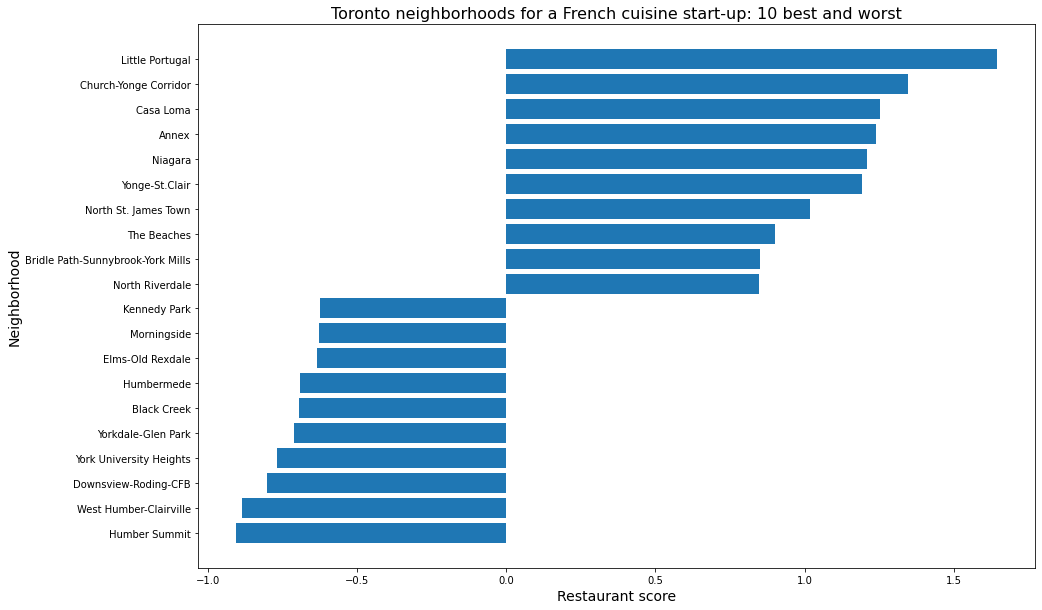

In [52]:
to_french=to_final[["Neighborhood", "Score"]]
to_french.sort_values(by='Score', inplace=True)
to_top=to_french.head(10).tail(10)
to_bottom=to_french.tail(10)
to_french=pd.concat([to_top, to_bottom])
x=to_french["Neighborhood"]
y=to_french["Score"]

plt.figure(figsize=(15, 10))
plt.barh(x,y)
plt.xlabel("Restaurant score", fontsize=14)
plt.ylabel("Neighborhood", fontsize=14)
plt.title("Toronto neighborhoods for a French cuisine start-up: 10 best and worst", fontsize=16)
plt.show()

####The location of the 10 best neighborhoods can be visualized using Folium:

In [151]:
to_top10=to_final.sort_values(by=['Score'], ascending=False).head(10)

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, neighborhood in zip(to_top10['Latitude'], to_top10['Longitude'], to_top10['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

###Let's check our variables
####What does the distribution of French-speakers look like?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


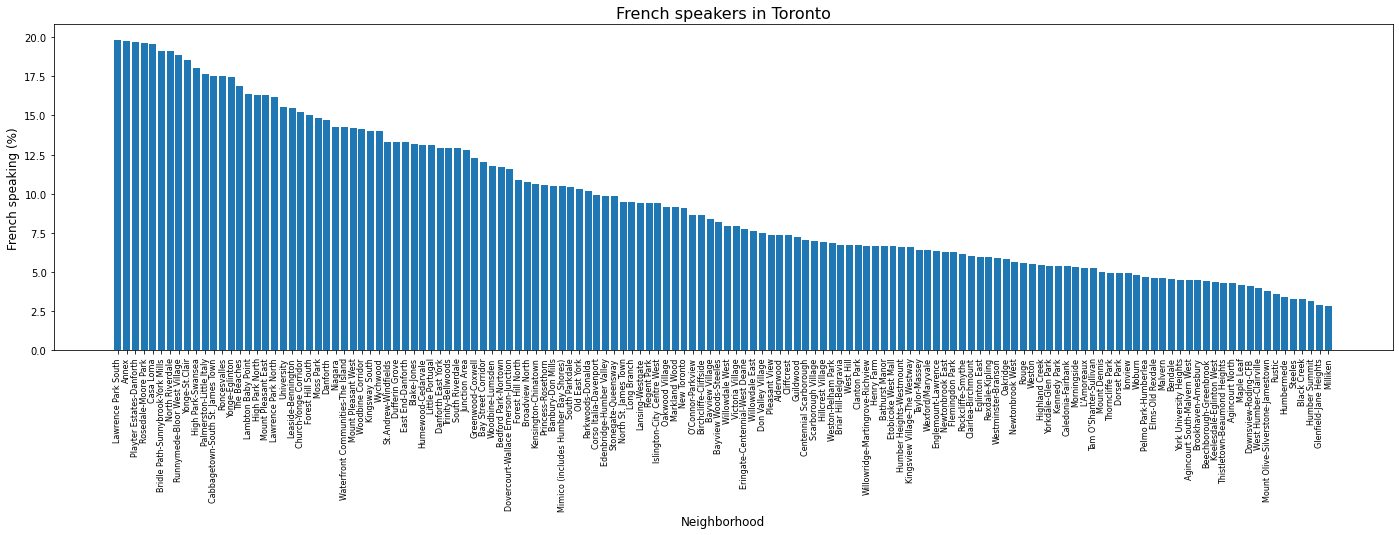

In [40]:
to_french=to_final[["Neighborhood", "French speaking (%)"]]
to_french.sort_values(by='French speaking (%)', ascending=False, inplace=True)

x=to_french["Neighborhood"]
y=to_french["French speaking (%)"]

plt.figure(figsize=(24, 6))
plt.bar(x,y)
plt.xlabel("Neighborhood", fontsize=12)
plt.ylabel("French speaking (%)", fontsize=12)
plt.title("French speakers in Toronto", fontsize=16)
plt.xticks(rotation=90, fontsize=8)
plt.show()

####So French speaking percentage ranges from roughly 3 to 20 % in the neighborhoods. Is French speaking rate correlated with other variables in our dataset, like income? 

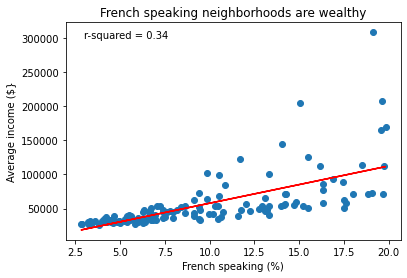

In [75]:
R_square = r2_score(to_norm["French speaking (%)"], to_norm["Average income ($}"])

plt.scatter(to_final["French speaking (%)"], to_final["Average income ($}"])
plt.xlabel("French speaking (%)")
plt.ylabel("Average income ($}")
plt.title("French speaking neighborhoods are wealthy")
m, b = np.polyfit(to_final["French speaking (%)"], to_final["Average income ($}"], 1)
plt.plot(to_final["French speaking (%)"], m*to_final["French speaking (%)"]+b, c = "r")
#plt.annotate("r-squared = {:.2f}".format(r2_score(to_norm["French speaking (%)"], to_norm["Average income ($}"]), (3,300000)))
plt.annotate("r-squared = {:.2f}".format(R_square), (3,300000))
plt.show()

There is a correlation, although the r2-score is not very high. Simple linear regression is probably not optimal here, I  leave it to the reader to explore it further if interested. It is a good thing that choosen variables correlate as they would synergistically improve the final score.

####Let's finally have a look at which variables are most influential for the score

Text(0.5, 0.98, 'Correlation between choosen variables and restaurant score')

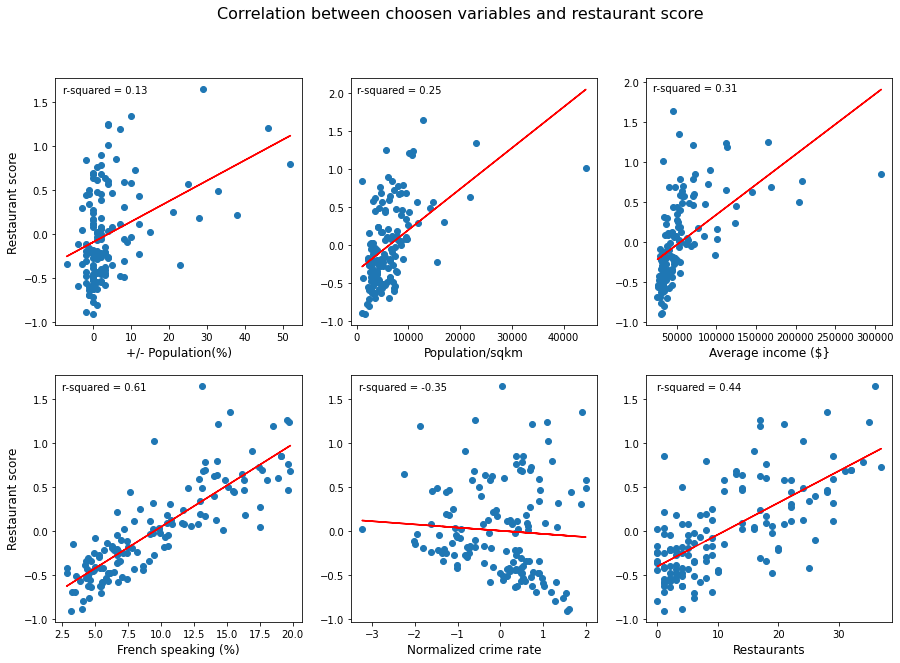

In [94]:
to_norm["Normalized crime rate"]=to_norm["Crime rate inv"]*-1
y = to_final["Score"]
#Calculating R2-scores
R1 = r2_score(to_norm["+/- Population(%)"], y)
R2 = r2_score(to_norm["Population/sqkm"], y)
R3 = r2_score(to_norm["Average income ($}"], y)
R4 = r2_score(to_norm["French speaking (%)"], y)
R5 = r2_score(to_norm["Normalized crime rate"], y)
R6 = r2_score(to_norm["Restaurant Total freq"], y)

#Subplotting
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
ax6 = f.add_subplot(236)

ax.scatter(to_final["+/- Population(%)"],y)
ax.set_xlabel("+/- Population(%)", fontsize=12)
ax.set_ylabel("Restaurant score", fontsize=12)
m, b = np.polyfit(to_final["+/- Population(%)"], y, 1)
ax.plot(to_final["+/- Population(%)"], m*to_final["+/- Population(%)"]+b, c = "r")
ax.annotate("r-squared = {:.2f}".format(R1), (-8,1.6))

ax2.scatter(to_final["Population/sqkm"],y)
ax2.set_xlabel("Population/sqkm", fontsize=12)
m, b = np.polyfit(to_final["Population/sqkm"], y, 1)
ax2.plot(to_final["Population/sqkm"], m*to_final["Population/sqkm"]+b, c = "r")
ax2.annotate("r-squared = {:.2f}".format(R2), (0,2))

ax3.scatter(to_final["Average income ($}"],y)
ax3.set_xlabel("Average income ($}", fontsize=12)
m, b = np.polyfit(to_final["Average income ($}"], y, 1)
ax3.plot(to_final["Average income ($}"], m*to_final["Average income ($}"]+b, c = "r")
ax3.annotate("r-squared = {:.2f}".format(R3), (20000,1.89))

ax4.scatter(to_final["French speaking (%)"],y)
ax4.set_xlabel("French speaking (%)", fontsize=12)
ax4.set_ylabel("Restaurant score", fontsize=12)
m, b = np.polyfit(to_final["French speaking (%)"], y, 1)
ax4.plot(to_final["French speaking (%)"], m*to_final["French speaking (%)"]+b, c = "r")
ax4.annotate("r-squared = {:.2f}".format(R4), (2.5,1.6))

ax5.scatter(to_norm["Normalized crime rate"],y)
ax5.set_xlabel("Normalized crime rate", fontsize=12)
m, b = np.polyfit(to_norm["Normalized crime rate"], y, 1)
ax5.plot(to_norm["Normalized crime rate"], m*to_norm["Normalized crime rate"]+b, c = "r")
ax5.annotate("r-squared = {:.2f}".format(R5), (-3.3,1.6))

ax6.scatter(to_final["Restaurant Total freq"],y)
ax6.set_xlabel("Restaurants", fontsize=12)
m, b = np.polyfit(to_final["Restaurant Total freq"], y, 1)
ax6.plot(to_final["Restaurant Total freq"], m*to_final["Restaurant Total freq"]+b, c = "r")
ax6.annotate("r-squared = {:.2f}".format(R6), (0,1.6))

f.suptitle('Correlation between choosen variables and restaurant score', fontsize=16)

This is just a quick test with simple linear regression, some would likely fit better with e.g. polynomial regression. The main take-home message is that neighborhoods with a high proportion of French speakers seem to be the best predictor (r2=0.61). Crime rates are not correlated with the restaurant scoring, but is nevertheless of importance for many who wishes to open a venue and should therefore be taken into account in the final decision.

####Finally, let's check the contribution of the no. of French Restaurants/neighborhood to the score. Note, that since there are so few restaurants here, it makes more sense with a barplot:

<ErrorbarContainer object of 3 artists>

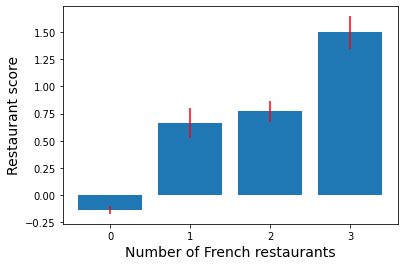

In [125]:
a = to_final.groupby(to_final['French Restaurant']).sem()
b = to_final.groupby(to_final['French Restaurant']).mean()
b.reset_index(inplace=True)
b["French Restaurant"]=b["French Restaurant"].astype(str)

plt.bar(b["French Restaurant"], b["Score"])
plt.xlabel("Number of French restaurants", fontsize=14)
plt.ylabel("Restaurant score", fontsize=14)
plt.errorbar(b["French Restaurant"],b["Score"], yerr=a["Score"], c="r", ls='none')

The number of French restaurants in a neighborhood is also likely important, but since there are quite few of them it is hard to draw definitive conclusions. In general, nearby restaurants can both raise attractivness of the neighborhood for costumers as well as increases competition, especially if they are in the same category. 

##Summary
Little Portugal is the top scorer for a French cuisine start-up. One has to bear in mind, however, that there are already three French cuisines along with several other restaurants in the neighborhood, which makes it more competitive. Conversely, if one is looking for a neighborhood devoid of a French restaurant (least competitive), two placeed in the top 10 list: North St. James Town and Bridle Path-Sunnybrook-York Mills. These are quite dissimilar, North St. James Town is densely populated, with relatively low average income; Bridle Path-Sunnybrook-York Mills has a very high average income but is relatively sparsely populated and have only one restaurant. 

To conclude, this analysis has provided putative neighborhoods for a French cusine start-up and could serve as basis for further exploration of the areas.  